In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Imports:

In [2]:
#all  imports
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from math import isnan
from networkx.algorithms.community.centrality import girvan_newman

All functions:

In [3]:
#read all data from CSV file, and show info about duplicates in it
def readFromCsvCheckDuplicates(filePath):
    temp = pd.read_csv(filePath)
    print("Dimensions of data: " + str(temp.shape))
    tempDuplicates = temp[temp.duplicated()]
    if tempDuplicates.shape[0] == 0:
        print("No duplicates in data")
    else:
        print("Duplicates are:")
        print(tempDuplicates)
    return temp
#plot all data from column in dataframe
def plot_column(nameOfColumn):
    atp_matches_data_2018.groupby(nameOfColumn)['id']\
        .nunique().plot(kind='bar')
    plt.show()
#check if column contains nulls, and if it is unique
def checkColumnNullsAndUnique(dataTmp):
    for column in dataTmp.columns:
        print(column+"\\\t"+ str(dataTmp[column].isnull().values.any())
              + "\\\t"+str(dataTmp[column].is_unique))
#set default values for rank and points if they are nulls
def checkNullsRankAndPoints(rankColumn, rankPointsColumn):
    maska = (atp_matches_data_2018[rankColumn].isnull())
    for index, row in atp_matches_data_2018[maska].iterrows():
        atp_matches_data_2018.at[index,rankColumn] = 2272
        atp_matches_data_2018.at[index,rankPointsColumn] = 0

Reading and cleaning data:

In [4]:
#read all matches from 2018
atp_matches_data_2018 = readFromCsvCheckDuplicates("atp_matches_2018.csv")

Dimensions of data: (2889, 49)
No duplicates in data


In [5]:
#read all player info
atp_players_data_info = readFromCsvCheckDuplicates("atp_players.csv")

Dimensions of data: (54975, 6)
No duplicates in data


In [6]:
#read only 2018 atp ranking data
data_rankings_atp_10s = readFromCsvCheckDuplicates("atp_rankings_10s.csv")
data_rankings_atp_10s = data_rankings_atp_10s[
    (data_rankings_atp_10s['ranking_date'] >= 20180101) &
    (data_rankings_atp_10s['ranking_date'] < 20190101)]
data_rankings_atp_10s = data_rankings_atp_10s.drop_duplicates()
print(data_rankings_atp_10s.shape)

Dimensions of data: (916296, 4)
Duplicates are:
        ranking_date  rank  player  points
855847      20181231     1  104925  9045.0
855849      20181231     2  104745  7480.0
855851      20181231     3  103819  6420.0
855853      20181231     4  100644  6385.0
855855      20181231     5  105223  5300.0
...              ...   ...     ...     ...
857194      20181231   672  201945     1.0
857196      20181231   676  126106     1.0
857198      20181231   677  106156     1.0
857200      20181231   677  126091     1.0
857202      20181231   677  126273     1.0

[678 rows x 4 columns]
(92334, 4)


In [7]:
#add id column to matches data
atp_matches_data_2018['id'] = atp_matches_data_2018.index
print(atp_matches_data_2018.shape)

(2889, 50)


In [8]:
#delete unnecessary columns from matches data
list_to_delete_columns = ['draw_size', 'match_num', 'winner_seed',
                          'winner_entry', 'winner_ht', 'loser_ht',
                          'loser_seed', 'loser_entry', 'score',
                          'best_of', 'minutes', 'w_ace', 'w_df',
                          'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
                          'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace',
                          'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon',
                          'l_2ndWon', 'l_SvGms', 'l_bpSaved',
                          'l_bpFaced', 'winner_name', 'winner_hand',
                          'winner_age', 'winner_ioc', 'loser_name',
                          'loser_hand', 'loser_age', 'loser_ioc']
for column in list_to_delete_columns:
    del atp_matches_data_2018[column]
print(atp_matches_data_2018.shape)

(2889, 13)


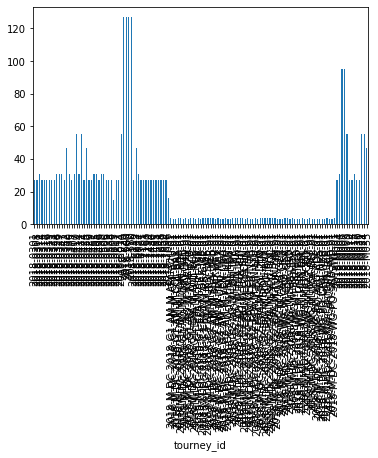

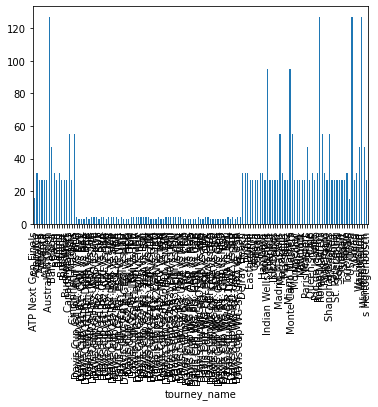

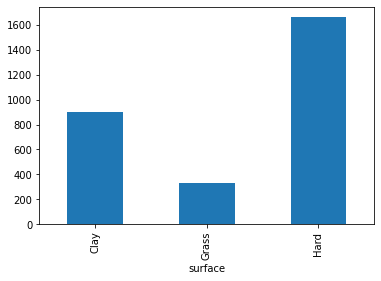

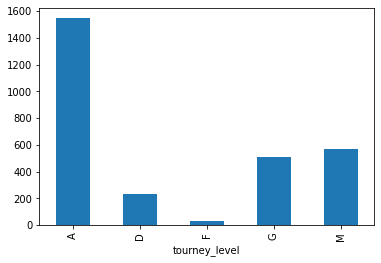

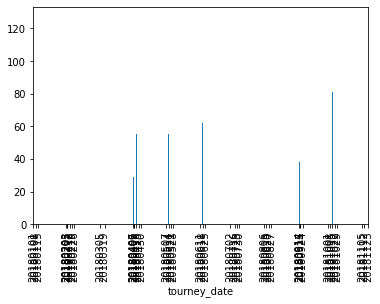

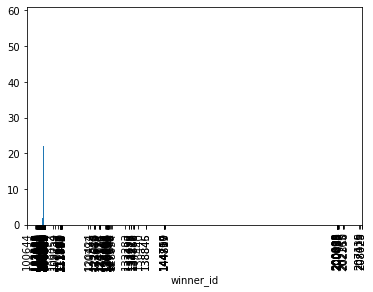

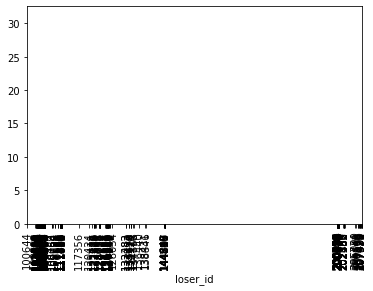

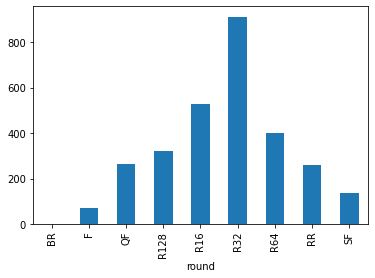

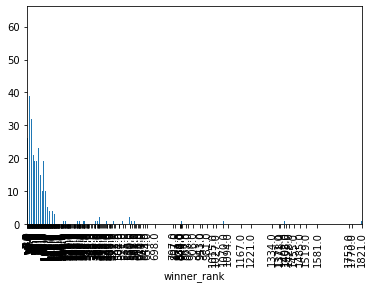

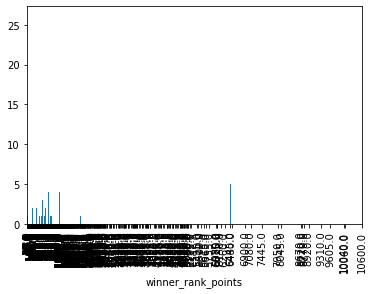

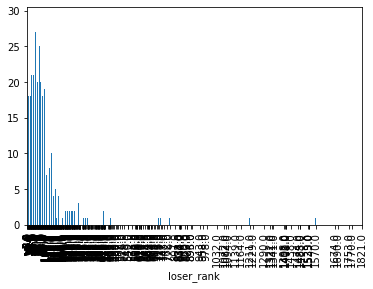

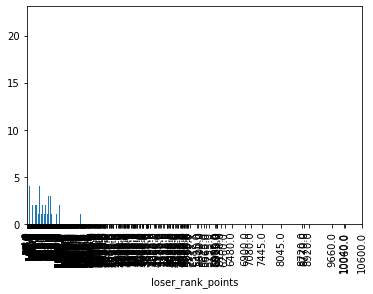

KeyboardInterrupt: 

In [10]:
#plotting all columns
#for column in atp_matches_data_2018.columns:
    #plot_column(column)

In [ ]:
#set default values if null in winner and loser rank and points data
checkNullsRankAndPoints('winner_rank','winner_rank_points')
checkNullsRankAndPoints('loser_rank','loser_rank_points')

In [ ]:
#check if columns are nulls or unique
checkColumnNullsAndUnique(atp_matches_data_2018)
print('---------------------------------------')
checkColumnNullsAndUnique(atp_players_data_info)

In [ ]:
#get all players from all matches
list_winner_id = set(atp_matches_data_2018['winner_id'].unique())
list_loser_id = set(atp_matches_data_2018['loser_id'].unique())
all_current_user_ids = list_winner_id.union(list_loser_id)
print(len(all_current_user_ids))

Making Graph:

In [ ]:
#counting different tourneys
all_pairs_player_tourney = set()
for _,row in atp_matches_data_2018.iterrows():
   all_pairs_player_tourney.add((row['winner_id'], row['tourney_id']))
   all_pairs_player_tourney.add((row['loser_id'], row['tourney_id']))

tourneys_counter_by_player = {}
for pair in all_pairs_player_tourney:
    if pair[0] in tourneys_counter_by_player.keys():
        tourneys_counter_by_player[pair[0]] +=1
    else:
        tourneys_counter_by_player[pair[0]]=1


In [ ]:
#putting all nodes in graph
G = nx.Graph()
for userId in all_current_user_ids:
    player = atp_players_data_info[atp_players_data_info['id']==userId]
    all_player_rankings = data_rankings_atp_10s[data_rankings_atp_10s['player']==userId]
    temp_rank = all_player_rankings['rank'].dropna().mean()
    if isnan(temp_rank):
        temp_rank=2272.0
    temp_points=all_player_rankings['points'].dropna().mean()
    if isnan(temp_points):
        temp_points=0.0
    G.add_node(str(userId), name=player['name'].values[0],
               surname=player['surname'].values[0],
               country=player['country'].values[0],
               hand=player['hand'].values[0],
               dateOfBirth=player['date_of_birth'].values[0],
               tourneyNum=tourneys_counter_by_player[userId],
               avgRank=temp_rank,
               avgPoints=temp_points)
print(nx.info(G))

In [ ]:
#creating edges
for _, match in atp_matches_data_2018.iterrows():
    if G.has_edge(str(match['winner_id']), str(match['loser_id'])):
        G[str(match['winner_id'])][str(match['loser_id'])]['weight']+=1
    else:
        G.add_edge(str(match['winner_id']), str(match['loser_id']), weight=1)
        G[str(match['winner_id'])][str(match['loser_id'])]['lowerId']=0
        G[str(match['winner_id'])][str(match['loser_id'])]['higherId']=0

    if match['winner_id']>match['loser_id']:
        G[str(match['winner_id'])][str(match['loser_id'])]['higherId']+=1
    else:
        G[str(match['winner_id'])][str(match['loser_id'])]['lowerId']+=1
print(nx.info(G))

In [ ]:
#write to a file
output_path = "Basic2018.gml"
nx.write_gml(G, output_path)

In [ ]:
#pitanje 2 - izbaciti citacemo iz gephija
sorted_by_degree = sorted(G.degree, key=lambda x: x[1], reverse=True)
for player in sorted_by_degree:
    player2 = atp_players_data_info[atp_players_data_info['id']==(int(player[0]))]
    print(player2)
    print(player[1])

In [ ]:
#pitanje 6
numOfPlayersByCountryCounter = {}
for player in G.degree:
    player2 = atp_players_data_info[atp_players_data_info['id']==(int(player[0]))]
    if player2['country'].values[0] in numOfPlayersByCountryCounter.keys():
        numOfPlayersByCountryCounter[player2['country'].values[0]] +=1
    else:
        numOfPlayersByCountryCounter[player2['country'].values[0]]=1
print(dict(sorted(numOfPlayersByCountryCounter.items(), key=lambda item: item[1], reverse=True)))
plt.bar(*zip(*numOfPlayersByCountryCounter.items()))
plt.show()

In [ ]:
sum = 0.0
for edge in G.edges:
    sum += G.get_edge_data(*edge)['weight']
sum /= G.number_of_edges()
print(sum)

In [ ]:
#pitanje 11
player_rank_to_edge_weight=pd.DataFrame(columns=['avgWeight', 'rank'])
for node in G.nodes:
    sum = 0.0
    counter = 0
    for neighbor in nx.neighbors(G, node):
        sum+=G[node][neighbor]['weight']
        counter+=1
    sum /= counter
    player_rank_to_edge_weight = player_rank_to_edge_weight.append(
        pd.DataFrame([[sum, G.nodes[node]['avgRank']]], columns=['avgWeight', 'rank']))
print(player_rank_to_edge_weight)

In [ ]:
#pitanje 11
player_rank_to_edge_weight.plot(x='rank', y='avgWeight', style='o')
plt.show()

In [ ]:
#pitanje 17
player_rank_to_degree=pd.DataFrame(columns=['degree', 'rank'])
for node in G.nodes:
    player_rank_to_degree = player_rank_to_degree.append(
        pd.DataFrame([[G.degree[node], G.nodes[node]['avgRank']]],
                     columns=['degree', 'rank']))
print(player_rank_to_degree)

In [ ]:
#pitanje 17
player_rank_to_degree.plot(x='rank', y='degree', style='o')
plt.show()

In [ ]:
#klasterisanje pitanje 10
id_player, clustering_coef = zip(*nx.clustering(G, weight = "weight").items())

nonZero = [(id_ig, cc)  for id_ig, cc in zip(id_player, clustering_coef) if cc > 0]

df = pd.DataFrame(nonZero, columns = ["id", "cc"])
df.sort_values('cc', inplace = True)
print(f"Max lokalni cc: {max(clustering_coef)}")
print(f"Prosečan cc: {nx.average_clustering(G)}")
print("Lokalni stepeni klasterisanja koji nisu nula:")
print(df)

In [ ]:
#asortativnost pitanje 10
# asortativnost na osnovu netežinskog stepena čvora
print(f"Koeficijent asortativnosti na osnovu netežinskog stepena čvora: "
      f"{nx.degree_assortativity_coefficient(G)}")

# asortativnost na osnovu težinskog stepena čvora
print(f"Koeficijent asortativnosti na osnovu težinskog stepena čvora: "
      f"{nx.degree_assortativity_coefficient(G, weight='weight')}")

In [ ]:
#pitanje 9
gn = girvan_newman(G)
print(gn)

In [ ]:
#pitanje 9
tuple(sorted(c) for c in next(gn))

In [ ]:
#pitanje 12
T = nx.k_core(G)
print(nx.info(T))
output_path = "core2018.gml"
nx.write_gml(T, output_path)
print(T.nodes)

In [ ]:

#pitanje 18
h, a = nx.hits(G)
print(dict(sorted(h.items(), key=lambda item: item[1], reverse=True)))
print('----------')
print(dict(sorted(a.items(), key=lambda item: item[1], reverse=True)))

In [ ]:
#pitanje 24
player_to_match_number = {}
for node in G.nodes:
    sum = 0.0
    for neighbor in nx.neighbors(G, node):
        sum+=G[node][neighbor]['weight']
    if sum in player_to_match_number.keys():
        player_to_match_number[sum]+=1
    else:
        player_to_match_number[sum]=1

print(player_to_match_number)
plt.bar(*zip(*player_to_match_number.items()))
plt.show()

In [ ]:
#pitanje 25
all_pairs_surface_tourney = set()
for _,row in atp_matches_data_2018.iterrows():
   all_pairs_surface_tourney.add((row['surface'], row['tourney_id']))

tourneys_counter_by_surface = {}
for pair in all_pairs_surface_tourney:
    if pair[0] in tourneys_counter_by_surface.keys():
        tourneys_counter_by_surface[pair[0]] +=1
    else:
        tourneys_counter_by_surface[pair[0]]=1
plt.bar(*zip(*tourneys_counter_by_surface.items()))
plt.show()

In [ ]:
#pitanje 26
all_pairs_surface_matches = {}
for _,row in atp_matches_data_2018.iterrows():
   if row['surface'] in all_pairs_surface_matches.keys():
        all_pairs_surface_matches[row['surface']] += 1
   else:
        all_pairs_surface_matches[row['surface']]=1

plt.bar(*zip(*all_pairs_surface_matches.items()))
plt.show()

In [ ]:
#pitanje 13
bridges = list(nx.bridges(G))
player_bridges = {}
for edge in bridges:
    if edge[0] in player_bridges.keys():
        player_bridges[edge[0]] += 1
    else:
        player_bridges[edge[0]]=1
    if edge[1] in player_bridges.keys():
        player_bridges[edge[1]] += 1
    else:
        player_bridges[edge[1]]=1
print(dict(sorted(player_bridges.items(), key=lambda item: item[1], reverse=True)))

In [ ]:
# možemo iskoristiti networkx.draw_network da predstavimo egomrežu tog čvora
ego_mreza_nadal = nx.ego_graph(G, '104745')
ego_mreza_djokovic = nx.ego_graph(G, '104925')
ego_mreza_federer = nx.ego_graph(G, '103819')
output_path = "egoNadal2018.gml"
nx.write_gml(ego_mreza_nadal, output_path)
output_path = "egoDjokovic2018.gml"
nx.write_gml(ego_mreza_djokovic, output_path)
output_path = "egoFederer2018.gml"
nx.write_gml(ego_mreza_federer, output_path)
U=ego_mreza_djokovic
for node in ego_mreza_nadal.nodes:
    if not(node in U.nodes):
        U.add_node(node, name=ego_mreza_nadal.nodes[node]['name'],
               surname=ego_mreza_nadal.nodes[node]['surname'],
               country=ego_mreza_nadal.nodes[node]['country'],
               hand=ego_mreza_nadal.nodes[node]['hand'],
               dateOfBirth=ego_mreza_nadal.nodes[node]['dateOfBirth'],
               tourneyNum = ego_mreza_nadal.nodes[node]['tourneyNum'],
               avgRank=ego_mreza_nadal.nodes[node]['avgRank'],
               avgPoints=ego_mreza_nadal.nodes[node]['avgPoints'])

for node in ego_mreza_federer.nodes:
    if not(node in U.nodes):
        U.add_node(node, name=ego_mreza_federer.nodes[node]['name'],
               surname=ego_mreza_federer.nodes[node]['surname'],
               country=ego_mreza_federer.nodes[node]['country'],
               hand=ego_mreza_federer.nodes[node]['hand'],
               dateOfBirth=ego_mreza_federer.nodes[node]['dateOfBirth'],
               tourneyNum = ego_mreza_federer.nodes[node]['tourneyNum'],
               avgRank=ego_mreza_federer.nodes[node]['avgRank'],
               avgPoints=ego_mreza_federer.nodes[node]['avgPoints'])

for edge in ego_mreza_nadal.edges:
    if edge in U.edges:
        U[edge[0]][edge[1]]["weight"] += ego_mreza_nadal[edge[0]][edge[1]]["weight"]
        U[edge[0]][edge[1]]['lowerId']+=ego_mreza_nadal[edge[0]][edge[1]]['lowerId']
        U[edge[0]][edge[1]]['higherId']+=ego_mreza_nadal[edge[0]][edge[1]]['higherId']
    else:
        U.add_edge(*edge, weight=ego_mreza_nadal[edge[0]][edge[1]]["weight"],
                    lowerId=ego_mreza_nadal[edge[0]][edge[1]]['lowerId'],
                    higherId=ego_mreza_nadal[edge[0]][edge[1]]['higherId'])
for edge in ego_mreza_federer.edges:
    if edge in U.edges:
        U[edge[0]][edge[1]]["weight"] += ego_mreza_federer[edge[0]][edge[1]]["weight"]
        U[edge[0]][edge[1]]['lowerId']+=ego_mreza_federer[edge[0]][edge[1]]['lowerId']
        U[edge[0]][edge[1]]['higherId']+=ego_mreza_federer[edge[0]][edge[1]]['higherId']
    else:
        U.add_edge(*edge, weight=ego_mreza_federer[edge[0]][edge[1]]["weight"],
                    lowerId=ego_mreza_federer[edge[0]][edge[1]]['lowerId'],
                    higherId=ego_mreza_federer[edge[0]][edge[1]]['higherId'])

output_path = "egoOfBigThree2018.gml"
nx.write_gml(U, output_path)